In [29]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [30]:
# Upload files to Vertex colab
from google.colab import files
uploaded = files.upload()

Saving california_housing_test.csv to california_housing_test (1).csv
Saving california_housing_train.csv to california_housing_train (1).csv


In [31]:

train_df = pd.read_csv('california_housing_train.csv')
test_df = pd.read_csv('california_housing_test.csv')

In [32]:

# Display the last few observations
test_df.tail()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
2995,-119.86,34.42,23.0,1450.0,642.0,1258.0,607.0,1.1790,225000.0
2996,-118.14,34.06,27.0,5257.0,1082.0,3496.0,1036.0,3.3906,237200.0
2997,-119.70,36.30,10.0,956.0,201.0,693.0,220.0,2.2895,62000.0
2998,-117.12,34.10,40.0,96.0,14.0,46.0,14.0,3.2708,162500.0
2999,-119.63,34.42,42.0,1765.0,263.0,753.0,260.0,8.5608,500001.0


In [33]:
# Get the shape of our train and test sets
print(f'The train set has {train_df.shape[0]} observations and {train_df.shape[1]} features.')
print(f'The test set has {test_df.shape[0]} observations and {test_df.shape[1]} features.')

The train set has 17000 observations and 9 features.
The test set has 3000 observations and 9 features.


In [34]:
# Data sanity check.
# Missing values assessment
train_df.info()
# Statistical summary of our train set
train_df.describe().T
# Check for duplicates
print(f'The train set has {train_df.duplicated().sum()} duplicates.')
print(f'The test set has {test_df.duplicated().sum()} duplicates.')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   housing_median_age  17000 non-null  float64
 3   total_rooms         17000 non-null  float64
 4   total_bedrooms      17000 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
 8   median_house_value  17000 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB
The train set has 0 duplicates.
The test set has 0 duplicates.


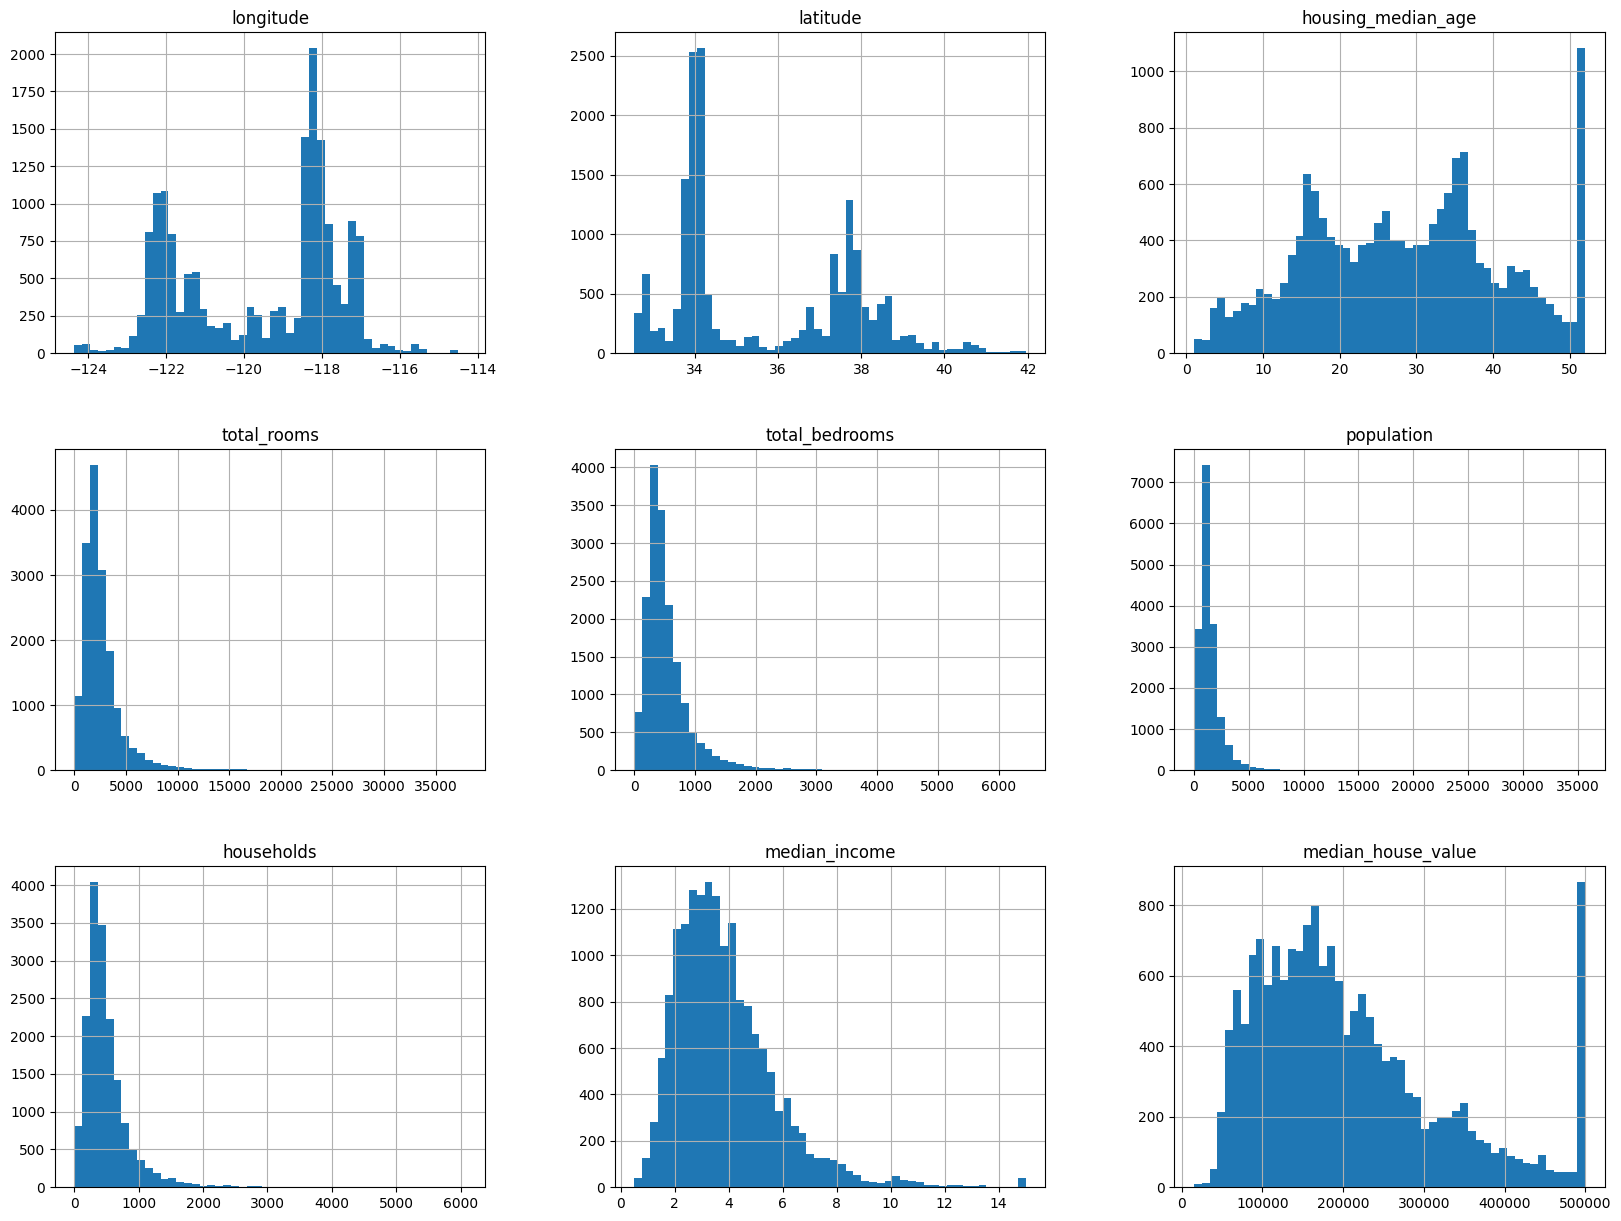

In [35]:
# Data explore
train_df.hist(bins=50, figsize=(20, 15))
plt.show();
fig = px.scatter_geo(data_frame=train_df,
                    lat='latitude',
                    lon='longitude',
                    color='median_house_value',
                    scope='usa')
fig.show()

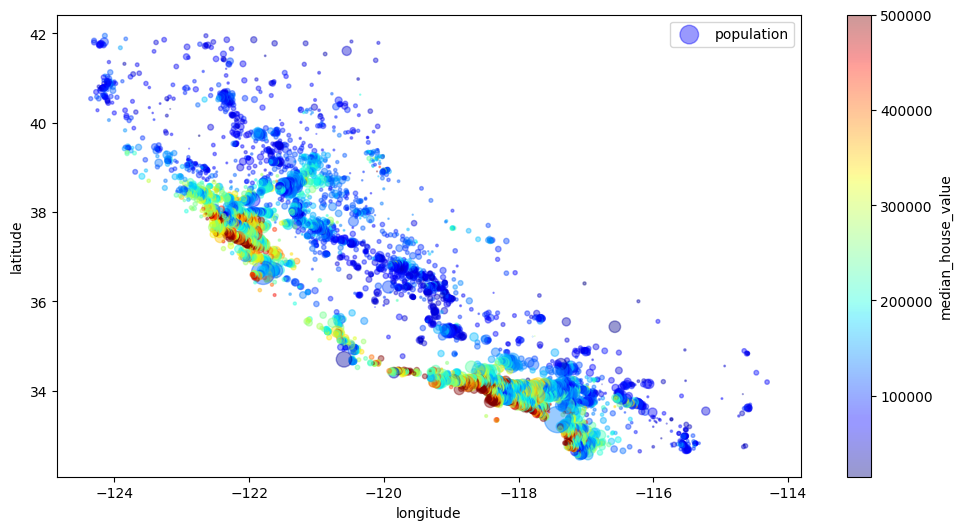

In [36]:
train_df.plot(kind='scatter', x = 'longitude', y = 'latitude', alpha = 0.4,
              s = train_df['population']/100, label = 'population', figsize = (12, 6),
              c = 'median_house_value',
              cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()
plt.show();

In [37]:
corr_matrix = train_df.corr()

# Look at how much each attribute correlates with median_house_value
corr_matrix['median_house_value'].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.691871
total_rooms,0.130991
housing_median_age,0.106758
households,0.061031
total_bedrooms,0.045783
population,-0.027850
longitude,-0.044982
latitude,-0.144917


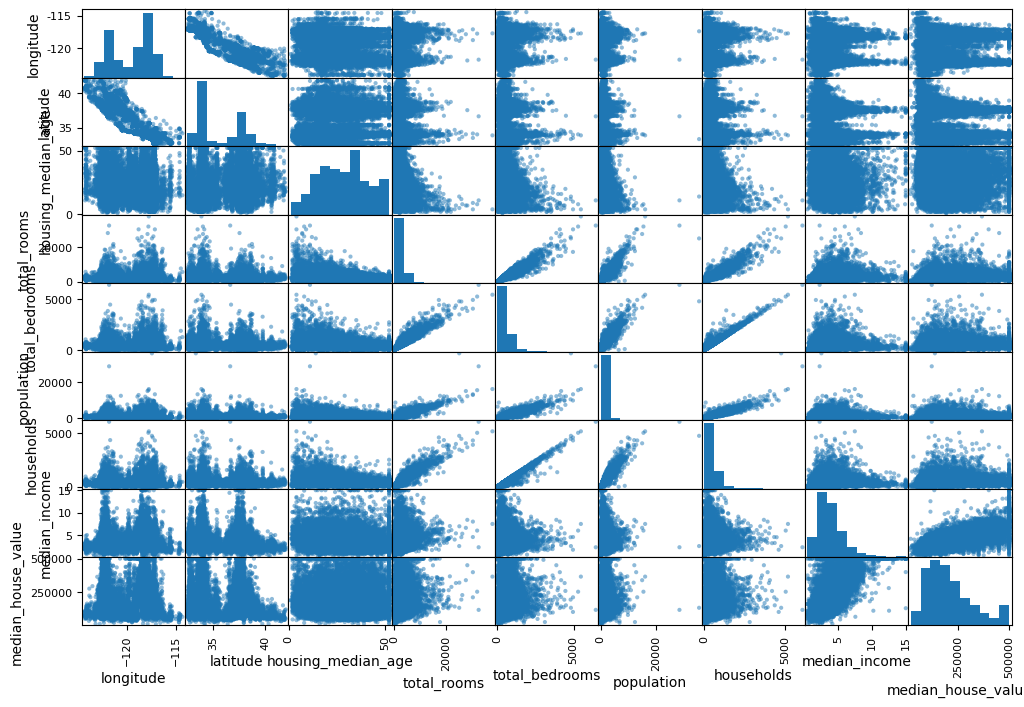

In [38]:
from pandas.plotting import scatter_matrix

scatter_matrix(train_df, figsize=(12, 8));

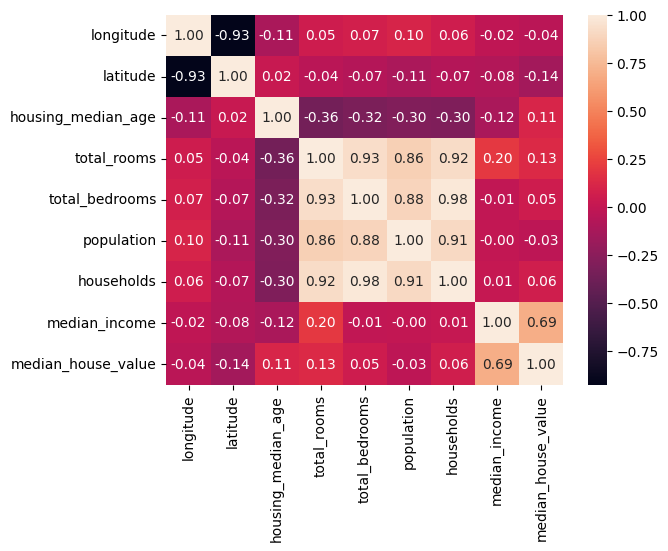

In [15]:
# Correlation heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.2f');

In [39]:
# Feature engineering
train_df["rooms_per_household"] = train_df["total_rooms"]/train_df["households"]
train_df["bedrooms_per_room"] = train_df["total_bedrooms"]/train_df["total_rooms"]
train_df["population_per_household"] = train_df["population"]/train_df["households"]

test_df["rooms_per_household"] = test_df["total_rooms"]/test_df["households"]
test_df["bedrooms_per_room"] = test_df["total_bedrooms"]/test_df["total_rooms"]
test_df["population_per_household"] = test_df["population"]/test_df["households"]

corr_matrix = train_df.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.691871
rooms_per_household,0.150081
total_rooms,0.130991
housing_median_age,0.106758
households,0.061031
total_bedrooms,0.045783
population,-0.027850
population_per_household,-0.042764
longitude,-0.044982


In [40]:
# Prepare data
# Get feature names
feature_names = train_df.columns

# Separate features from target

X = train_df.drop('median_house_value', axis=1)
y = train_df['median_house_value']
# Split the data into train and validation sets using stratification

X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.2,
                                                  random_state=42,
                                                  shuffle=True)
print(X_train.shape)
feature_names

(13600, 11)


Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'rooms_per_household', 'bedrooms_per_room',
       'population_per_household'],
      dtype='object')

In [41]:
"""
Define functions that build and train a model
The following code defines two functions:

build_model(my_learning_rate), which builds an empty model.
train_model(model, feature, label, epochs), which trains the model from the examples (feature and label) you pass.
"""

#@title Define the functions that build and train a model
def build_model(my_learning_rate):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  # A sequential model contains one or more layers.
  model = tf.keras.models.Sequential([
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(units=128, activation='relu',
                            kernel_initializer='he_normal'),
      tf.keras.layers.Dense(units=64, activation='relu'),
      tf.keras.layers.Dense(units=1, activation='linear')
])

  # Compile the model topography into code that
  # TensorFlow can efficiently execute. Configure
  # training to minimize the model's mean squared error.
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                loss="mean_absolute_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model

def train_model(model, feature, label, epochs, batch_size):
  """Train the model by feeding it data."""
  early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True)
  # Feed the feature values and the label values to the
  # model. The model will train for the specified number
  # of epochs, gradually learning how the feature values
  # relate to the label values.
  history = model.fit(x=feature,
                      y=label,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(X_val, y_val),
                      callbacks=[early_stopping])

  # Gather the trained model's weight and bias.
  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]

  # The list of epochs is stored separately from the
  # rest of history.
  epochs = history.epoch

  # Gather the history (a snapshot) of each epoch.
  hist = pd.DataFrame(history.history)

  # Specifically gather the model's root mean
  # squared error at each epoch.
  rmse = hist["root_mean_squared_error"]
  val_rmse = hist["val_root_mean_squared_error"]

  return trained_weight, trained_bias, epochs, rmse, val_rmse

print("Defined build_model and train_model")




Defined build_model and train_model


In [42]:
# specify hyper-params
learning_rate=0.01
epochs=200
my_batch_size=136

my_model = build_model(learning_rate)
trained_weight, trained_bias, epochs, rmse, val_rmse = train_model(my_model, X_train,
                                                         y_train, epochs,
                                                         my_batch_size)


Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 202235.1875 - root_mean_squared_error: 233247.3125 - val_loss: 119849.5156 - val_root_mean_squared_error: 160962.6406
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 85270.7891 - root_mean_squared_error: 114640.1641 - val_loss: 65254.1094 - val_root_mean_squared_error: 92138.9453
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 58552.6953 - root_mean_squared_error: 83235.6406 - val_loss: 59814.7383 - val_root_mean_squared_error: 83243.0781
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 55633.5469 - root_mean_squared_error: 79838.8203 - val_loss: 57068.3945 - val_root_mean_squared_error: 78061.7109
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 52112.4727 - root_mean_squared_error: 73928.4062 - val_loss: 52104.5195 - val_root_mean_squared_error: 74889.1641
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 52273.3711 - root_mean_squared_error: 75099.8125 - val_loss

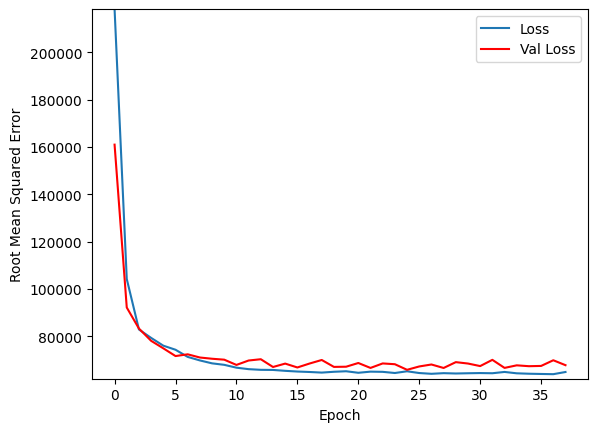

In [43]:
def plot_the_loss_curve(epochs, rmse):
  """Plot the loss curve, which shows loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.plot(epochs, val_rmse, label="Val Loss", color='red')
  plt.legend()
  plt.ylim([rmse.min()*0.97, rmse.max()])
  plt.show()

plot_the_loss_curve(epochs, rmse)

In [44]:
my_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_1                │ (136, 11)                   │              44 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (136, 128)                  │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (136, 64)                   │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (136, 1)                    │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,661 (115.87 KB)

 Trainable params: 9,879 (38.59 KB)

 Non-trainable params: 22 (88.00 B)

 Optimizer params: 19,760 (77.19 KB)

In [45]:
test_results = {}
test_label = test_df.pop('median_house_value')
test_results['my_model'] = my_model.evaluate(test_df, test_label, verbose=0)

In [46]:
pd.DataFrame(test_results, index=['Mean absolute error (MHV)', 'Mean squared error (MHV)']).T

,Mean absolute error (MHV),Mean squared error (MHV)
my_model,45552.539062,68273.875


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


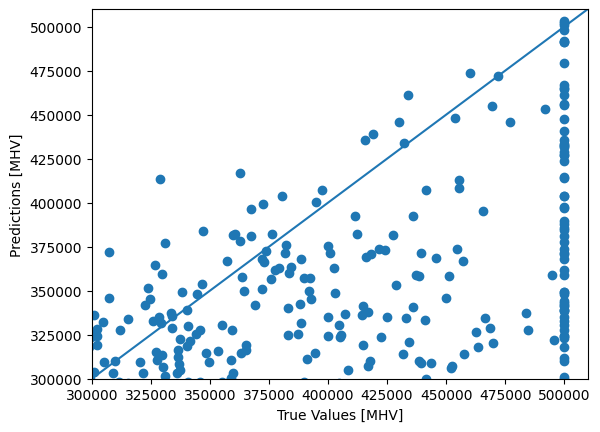

In [47]:
test_predictions = my_model.predict(test_df).flatten()

# a = plt.axes(aspect='equal')
plt.scatter(test_label, test_predictions)
plt.xlabel('True Values [MHV]')
plt.ylabel('Predictions [MHV]')
lims = [300000, 510000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

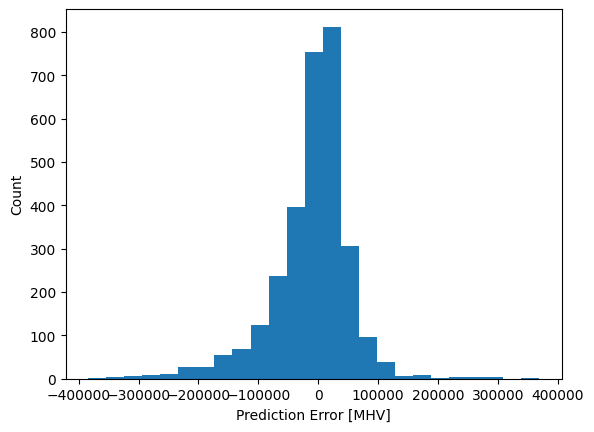

In [48]:

error = test_predictions - test_label
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MHV]')
_ = plt.ylabel('Count')

In [49]:
my_model.save('reg_dnn_model.keras')

In [51]:
# print the model weights
for layer in my_model.layers:
    weights = layer.get_weights()
    if weights:    # Check if the layer has weights (some layers might not)
      print("Layer Name:", layer.name)
      print("Weights:")
      #print(weights[0])    # Weight matrix
      print("Biases:")
      #print(weights[1])    # Biases vector
      print("------------------")

Layer Name: batch_normalization_1
Weights:
Biases:
------------------
Layer Name: dense_3
Weights:
Biases:
------------------
Layer Name: dense_4
Weights:
Biases:
------------------
Layer Name: dense_5
Weights:
Biases:
------------------


In [53]:
# save weights
my_model.save_weights('reg_dnn_model.weights.h5')

In [55]:

# the above mentioned might have returned an empty file. Here is what worked
import h5py
def save_weights_to_h5(model, output_file_name):
  """
  Saves weights and biases from a Keras model to an HDF5 file.

  Args:
      model: A Keras model.
      output_file_name: The name of the HDF5 file to save the weights to.

  Returns:
      None. """

  with h5py.File(output_file_name, 'w') as outfile:
    for i, layer in enumerate(model.layers):
      weights = layer.get_weights()
      if weights:
        layer_group = outfile.create_group(layer.name)
        layer_group.create_dataset('weights', data=weights[0])
        layer_group.create_dataset('bias', data=weights[1])

output_file = 'reg_dnn_model_weights.h5'
save_weights_to_h5(my_model, output_file)

In [57]:

# Download the file
from google.colab import files
files.download('reg_dnn_model_weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [58]:
# Download the file
from google.colab import files
files.download('reg_dnn_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [59]:
# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(my_model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open("reg_dnn_model.tflite", "wb") as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmp13dowdgl'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(136, 11), dtype=tf.float32, name='keras_tensor_5')
Output Type:
  TensorSpec(shape=(136, 1), dtype=tf.float32, name=None)
Captures:
  134255852760304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134255852755552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134255852749040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134255852759952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134255852755024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134255852837824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134255852838880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134255852838352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134255852842400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134255853092928: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [60]:
# Download the file
from google.colab import files
files.download('reg_dnn_model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>